In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from torchvision import transforms
from PIL import Image
from scipy.ndimage import gaussian_filter

def unit_norm_stable(x: torch.Tensor, reg: float = 1.0):
    norm = torch.norm(x, dim=-1, keepdim=True) + reg
    return x / norm

def preprocess_dict(dictionary: np.ndarray, reg: float = 1.0) -> torch.Tensor:
    dict_tensor = torch.from_numpy(dictionary).float()
    dict_tensor -= dict_tensor.mean(dim=1, keepdim=True)
    dict_tensor = unit_norm_stable(dict_tensor, reg=reg)
    return dict_tensor.cuda()  # Move to GPU

def extract_patches(img: torch.Tensor, patch_size: int, stride: int) -> torch.Tensor:
    img = img.unsqueeze(0).unsqueeze(0)  # [B, C, H, W]
    patches = F.unfold(img, kernel_size=patch_size, stride=stride)
    patches = patches.permute(0, 2, 1).squeeze(0)  # [num_patches, patch_size^2]
    return patches

def compute_quality_map(img: np.ndarray, dictionary: np.ndarray, stride: int = 16, alpha: float = 300.0, beta: float = 1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_tensor = torch.nn.functional.sigmoid(torch.from_numpy(img).float().to(device) / 255.0)
    patch_size = int(np.sqrt(dictionary.shape[0]))
    tile_size = patch_size * patch_size

    dict_tensor = preprocess_dict(dictionary, reg=beta)

    patches = extract_patches(img_tensor, patch_size, stride)  # [n_patches, tile_size]
    patches -= patches.mean(dim=1, keepdim=True)
    patches = unit_norm_stable(patches, reg=alpha)

    # print(patches.shape, dict_tensor.shape)

    sim_matrix = patches @ dict_tensor  # Cosine similarity since vectors are unit-norm
    max_sim, _ = torch.max(sim_matrix, dim=1)

    # Create output image
    nrows = (img.shape[0] - patch_size) // stride + 1
    ncols = (img.shape[1] - patch_size) // stride + 1
    quality_map = torch.zeros_like(img_tensor)

    p = 0
    for row in range(0, img.shape[0] - patch_size + 1, stride):
        for col in range(0, img.shape[1] - patch_size + 1, stride):
            quality_map[row:row + patch_size, col:col + patch_size] = max_sim[p]/0.0015
            p += 1

    return quality_map.cpu().numpy()

def process_image(img_path, dictionary, out_path, sigma=7):
    img = Image.open(img_path).convert("L")
    img_np = np.array(img)

    quality = compute_quality_map(img_np, dictionary)
    # print(quality.max(), quality.min(), quality.mean())
    quality_smooth = gaussian_filter(quality, sigma=sigma)

    quality_img = Image.fromarray((255 * quality_smooth).astype(np.uint8))
    quality_img.save(out_path)

def batch_process(img_dir, dict_path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    dictionary = np.load(dict_path)

    for fname in sorted(os.listdir(img_dir)):
        if fname.endswith('.png'):
            in_path = os.path.join(img_dir, fname)
            out_path = os.path.join(out_dir, fname)
            process_image(in_path, dictionary, out_path)



In [39]:

batch_process("/home/gabriel/fingerprint-enhancement/output/enh", 
"/storage/gabriel/ridge_dict.npy", 
"/home/gabriel/fingerprint-enhancement/output/quality_maps")

KeyboardInterrupt: 

In [67]:
from matplotlib import pyplot as plt

def plot_patch(patch, title=None, cmap='gray'):
    """
    Plot a single patch using matplotlib.
    
    Args:
        patch (torch.Tensor or np.ndarray): Patch of shape (H, W) or (1, H, W).
        title (str, optional): Title for the plot.
        cmap (str): Colormap to use, default is 'gray'.
    """
    if isinstance(patch, torch.Tensor):
        patch = patch.squeeze().cpu().numpy()
    else:
        patch = np.squeeze(patch)
    
    plt.imshow(patch, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

img_path = "/home/gabriel/fingerprint-enhancement/output/enh/b1048_t.png"
dictionary = np.load("/storage/gabriel/ridge_dict.npy")

img = Image.open(img_path).convert("L")
img_np = np.array(img)
img = img_np

stride = 16
alpha = 300.0
beta = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_tensor = torch.nn.functional.sigmoid(torch.from_numpy(img).float().to(device) / 255.0)
patch_size = int(np.sqrt(dictionary.shape[0]))
tile_size = patch_size * patch_size

dict_tensor = preprocess_dict(dictionary, reg=beta)

patches = extract_patches(img_tensor, patch_size, stride)  # [n_patches, tile_size]
patches -= patches.mean(dim=1, keepdim=True)
patches = unit_norm_stable(patches, reg=alpha)

# print(patches.shape, dict_tensor.shape)

sim_matrix = patches @ dict_tensor  # Cosine similarity since vectors are unit-norm
max_sim, _ = torch.max(sim_matrix, dim=1)

# Create output image
nrows = (img.shape[0] - patch_size) // stride + 1
ncols = (img.shape[1] - patch_size) // stride + 1
quality_map = torch.zeros_like(img_tensor)

p = 0
for row in range(0, img.shape[0] - patch_size + 1, stride):
    for col in range(0, img.shape[1] - patch_size + 1, stride):
        quality_map[row:row + patch_size, col:col + patch_size] = max_sim[p]/0.0015
        p += 1



In [66]:
max_sim.max()

tensor(0.0015, device='cuda:0')

In [ ]:
img/255

array([[0.43529412, 0.43529412, 0.44313725, ..., 0.52156863, 0.50588235,
        0.51372549],
       [0.46666667, 0.46666667, 0.4745098 , ..., 0.53333333, 0.5254902 ,
        0.54117647],
       [0.49019608, 0.50588235, 0.52156863, ..., 0.54901961, 0.53333333,
        0.54901961],
       ...,
       [0.51764706, 0.52156863, 0.5254902 , ..., 0.55294118, 0.50980392,
        0.51764706],
       [0.50980392, 0.5254902 , 0.5254902 , ..., 0.55294118, 0.51764706,
        0.51764706],
       [0.52941176, 0.52941176, 0.52156863, ..., 0.55686275, 0.53333333,
        0.52156863]], shape=(768, 800))

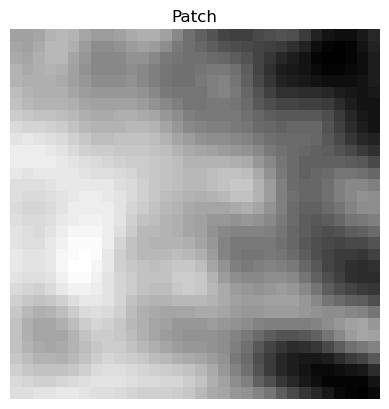

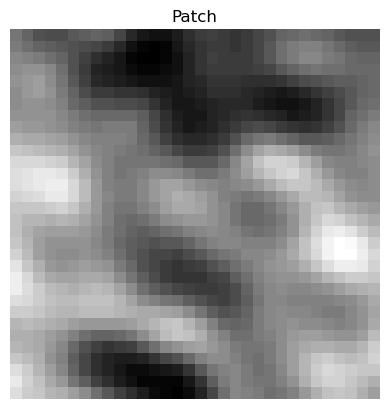

In [63]:
for patch in patches[100:102,:]:
    plot_patch(patch.reshape((32,32)), title="Patch")

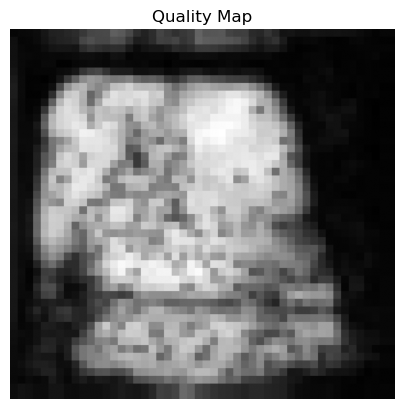

In [72]:
plot_patch(quality_map, title="Quality Map")